# ⚛️ H₃⁺ Noiseless VQE — UCC-S vs UCC-D vs UCCSD

This notebook compares three chemistry-inspired VQE ansatzes for the trihydrogen
cation **H₃⁺** using the production API:

    from vqe.core import run_vqe

Each ansatz is evaluated under identical conditions:
- Noiseless simulation (`default.qubit`)
- Optimizer: Adam
- 60 optimisation steps

Ansätze compared:
- **UCC-S** — singles only
- **UCC-D** — doubles only
- **UCCSD** — singles + doubles

For each ansatz we compute:
- Convergence curve
- Final energy
- Final statevector

This notebook is a pure client of the VQE package.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import os, sys

# Local imports from the installed package
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe_qpe_common.molecules import get_molecule_config
from vqe.core import run_vqe
from vqe_qpe_common.plotting import IMG_DIR
from vqe_qpe_common.molecule_viz import plot_molecule


In [3]:
# -------------------------------------------------------------
# Molecular system: H₃⁺
# -------------------------------------------------------------
mol = get_molecule_config("H3+")

symbols = mol["symbols"]
coordinates = mol["coordinates"]
basis = mol["basis"]
charge = mol["charge"]

ham, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=charge, basis=basis
)
hf = qchem.hf_state(2, qubits)

print(f"H₃⁺ → {qubits} qubits")
print("HF state =", "|" + "".join(str(int(x)) for x in hf) + "⟩")

H₃⁺ → 6 qubits
HF state = |110000⟩


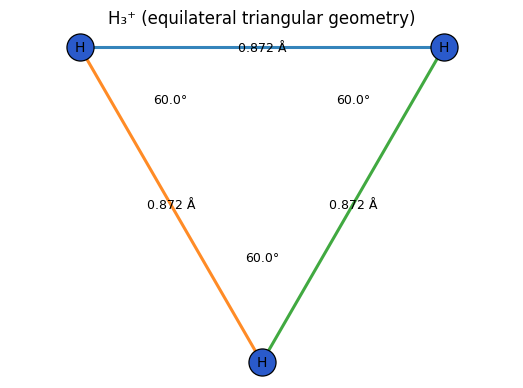

In [4]:
plot_molecule(
    symbols,
    coordinates,
    title="H₃⁺ (equilateral triangular geometry)",
    bonds=[(0, 1), (1, 2), (2, 0)],
    angles=[(0, 1, 2), (1, 2, 0), (2, 0, 1)],
    show_bond_lengths=True,
    show_atom_indices=False,
)
plt.show()


In [5]:
# -------------------------------------------------------------
# Run VQE for UCC-S / UCC-D / UCCSD
# -------------------------------------------------------------
ansatzes = ["UCC-S", "UCC-D", "UCCSD"]
results = {}

for ansatz in ansatzes:
    print(f"\n▶ Running VQE with ansatz: {ansatz}")
    rec = run_vqe(
        molecule="H3+",
        ansatz_name=ansatz,
        optimizer_name="Adam",
        n_steps=60,
        stepsize=0.2,
        noisy=False,
        plot=False,
        seed=0,
        force=False,
    )

    results[ansatz] = rec


▶ Running VQE with ansatz: UCC-S
Step 01/60: E = -1.254443 Ha
Step 02/60: E = -1.274613 Ha
Step 03/60: E = -1.287027 Ha
Step 04/60: E = -1.292067 Ha
Step 05/60: E = -1.293651 Ha
Step 06/60: E = -1.293646 Ha
Step 07/60: E = -1.297494 Ha
Step 08/60: E = -1.304970 Ha
Step 09/60: E = -1.314359 Ha
Step 10/60: E = -1.324545 Ha
Step 11/60: E = -1.333180 Ha
Step 12/60: E = -1.337818 Ha
Step 13/60: E = -1.338330 Ha
Step 14/60: E = -1.335804 Ha
Step 15/60: E = -1.332193 Ha
Step 16/60: E = -1.329109 Ha
Step 17/60: E = -1.327474 Ha
Step 18/60: E = -1.327676 Ha
Step 19/60: E = -1.329426 Ha
Step 20/60: E = -1.331831 Ha
Step 21/60: E = -1.334138 Ha
Step 22/60: E = -1.335749 Ha
Step 23/60: E = -1.336596 Ha
Step 24/60: E = -1.336557 Ha
Step 25/60: E = -1.335937 Ha
Step 26/60: E = -1.335255 Ha
Step 27/60: E = -1.335015 Ha
Step 28/60: E = -1.335405 Ha
Step 29/60: E = -1.336189 Ha
Step 30/60: E = -1.337171 Ha
Step 31/60: E = -1.338057 Ha
Step 32/60: E = -1.338568 Ha
Step 33/60: E = -1.338559 Ha
Step 34/6

KeyboardInterrupt: 

In [ ]:
# -------------------------------------------------------------
# Convergence comparison
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))

for ansatz in ansatzes:
    plt.plot(results[ansatz]["energies"], label=ansatz)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — UCC-S vs UCC-D vs UCCSD")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(IMG_DIR, "H3plus_Ansatz_Comparison.png"), dpi=300)
plt.show()

In [ ]:
# -------------------------------------------------------------
# Statevector reconstruction
# -------------------------------------------------------------
def reconstruct_state(rec):
    """Return complex statevector from stored real/imag components."""
    psi_r = np.array(rec["final_state_real"], dtype=float)
    psi_i = np.array(rec["final_state_imag"], dtype=float)
    return psi_r + 1j * psi_i

threshold = 1e-2

for ansatz in ansatzes:
    print("\n" + "-"*70)
    print(f"Final state decomposition for: {ansatz}")

    psi = reconstruct_state(results[ansatz])
    nz_idx = np.where(np.abs(psi) > threshold)[0]

    terms = []
    for idx in nz_idx:
        amp = psi[idx]
        bit = f"|{idx:0{qubits}b}⟩"
        if abs(amp.imag) < 1e-6:
            term = f"{amp.real:.4f}{bit}"
        else:
            term = f"({amp.real:.4f}+{amp.imag:.4f}j){bit}"
        terms.append(term)

    print(" |ψ⟩ =", " + ".join(terms))